# This is the simple workflow with graph

In [1]:
def function1(input1):
    return input1 + "from first function"

def function2(input2):
    return input2 + "and ochi from second function"

In [2]:
from langgraph.graph import Graph

In [3]:
workflow1 = Graph()

In [4]:
workflow1.add_node("function1", function1)

In [5]:
workflow1.add_node("function2", function2)

In [6]:
workflow1.add_edge("function1", "function2")

In [7]:
workflow1.set_entry_point("function1")

In [8]:
workflow1.set_finish_point("function2")

In [9]:
app1=workflow1.compile()

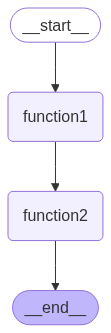

In [10]:
from IPython.display import Image, display

try:
    display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires extra dependencies and is optional
    print(e)

In [11]:
app1.invoke("hi this is ochi ")

'hi this is ochi from first functionand ochi from second function'

In [52]:
for output in app1.stream(input):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

TypeError: unsupported operand type(s) for +: 'method' and 'str'

# Adding LLM

In [12]:
from langchain_huggingface import HuggingFaceEmbeddings

# Wrapping the SentenceTransformer with LangChain-compatible embedding
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

In [13]:
from langchain_cerebras import ChatCerebras

llm = ChatCerebras(
    model="llama-3.3-70b",
)

In [14]:
# call the API
llm.invoke("Hello ?").content

'Hello. How can I assist you today?'

In [65]:
def function1(input):
    llm = ChatCerebras(model="llama-3.3-70b")
    #print(type(input))
    output = llm.invoke(input).content
    #print(type(input))
    return output

In [66]:
def function2(input):
    upper_case = input.upper()
    return upper_case

In [67]:
from langgraph.graph import Graph

In [68]:
workflow2 = Graph()

In [69]:
workflow2.add_node("llm", function1)

In [70]:
workflow2.add_node("upper_string", function2)

In [71]:
workflow2.add_edge("llm", "upper_string")

In [72]:
workflow2.set_entry_point("llm")
workflow2.set_finish_point("upper_string")

In [73]:
app2 = workflow2.compile()

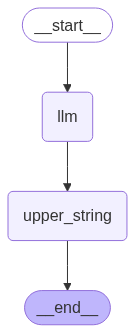

In [74]:
from IPython.display import Image, display

try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires extra dependencies and is optional
    print(e)

In [75]:
app2.invoke("What is the name of the creator of Rust programming language ? respond with only his name")

'RUSTAN HOLKOWICZ, BUT COMMONLY KNOWN AS  GRAYDON HOARE'

In [76]:
query = "What is the name of the creator of Rust programming language? Respond with only his name"
for output in app2.stream(query):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from llm
_______
Ralph Matheus but more commonly known as  Graydon Hoare


here is output from upper_string
_______
RALPH MATHEUS BUT MORE COMMONLY KNOWN AS  GRAYDON HOARE




## Let me create my own output token counter

In [77]:
def function3(input):
    token=input.split()
    token_number = len(token)
    token_number = f"total number of tokens are {token_number}"
    return token_number

In [78]:
workflow3 = Graph()
workflow3.add_node("llm", function1)

In [79]:
workflow3.add_node("token_counter", function3)

In [80]:
workflow3.add_edge("llm", "token_counter")

In [81]:
workflow3.set_entry_point("llm")

In [82]:
workflow3.set_finish_point("token_counter")

In [84]:
app3 = workflow3.compile()

In [85]:
app3.invoke("What is Ochi ?")

'total number of tokens are 156'

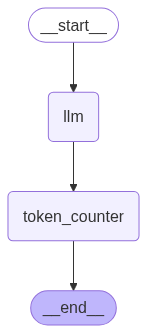

In [86]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires extra dependencies and is optional
    print(e)

# Adding Rag

In [87]:
from langchain_huggingface import HuggingFaceEmbeddings

# Wrapping the SentenceTransformer with LangChain-compatible embedding
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

In [88]:
from langchain_cerebras import ChatCerebras

llm = ChatCerebras(
    model="llama-3.3-70b",
)

In [89]:
llm.invoke("hi").content

'Hi. How can I help you today?'

In [90]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [93]:
loader = DirectoryLoader("../data", glob="./*.txt", loader_cls=TextLoader)
docs=loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

db = Chroma.from_documents(new_docs, embedding)
retriever = db.as_retriever(search_kwargs={"k":3})

query = "What is meta Llama3?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': '../data/stuff.txt'}
by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': '../data/stuff.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': '../data/stuff.txt'}
page_content='services use a Llama 3 model.[12] Reception was mixed, with some users confused after Meta AI told' metadata={'source': '../data/stuff.txt'}


In [110]:
def function_1(AgentState):
    message = AgentState['messages']

    question = message[-1]

    complete_prompt = "Your task is to provide only the brief answer based on the user query. Don't include too much reasoning. Following is the user query: " + question

    response = llm.invoke(complete_prompt)

    AgentState['messages'].append(response.content)

    return AgentState

In [111]:
AgentState={}

In [112]:
AgentState["messages"] = []

In [113]:
AgentState

{'messages': []}

In [114]:
AgentState["messages"].append("hi, how are you ?")

In [115]:
AgentState

{'messages': ['hi, how are you ?']}

In [116]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [117]:
# Define a Langchain graph
from langgraph.graph import Graph
workflow4 = Graph()
workflow4.add_node("LLM", function_1)
workflow4.add_node("RAGtool", function_2)
workflow4.add_edge('LLM', 'RAGtool')
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app4 = workflow4.compile()

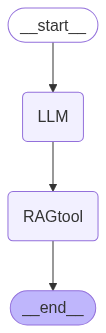

In [118]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [119]:
inputs = {"messages": ["Tell me about llama3 model"]}

In [120]:
for output in app4.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'LLM':
---
{'messages': ['Tell me about llama3 model', 'Llama3 is a large language model developed by Meta, designed to process and generate human-like language.']}

---

Output from node 'RAGtool':
---
The 8B parameter version of Llama 3 is described as being "surprisingly capable" given its size. Additionally, model weights for the first version of Llama were released to the research community.

---



In [123]:
loader2=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)
docs2=loader2.load()

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs2 = text_splitter.split_documents(documents=docs2)
doc_strings2 = [doc.page_content for doc in new_docs2]

In [124]:
db2 = Chroma.from_documents(new_docs2, embedding)
retriever2 = db2.as_retriever(search_kwargs={"k":3})

In [125]:
query = "Tell me about India's Industrial Growth?"
docs = retriever2.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': '../data2/stuff2.txt'}
India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': '../data2/stuff2.txt'}
page_content='Industrial Revival and Economic Optimism for India' metadata={'source': '../data2/stuff2.txt'}
page_content='for India’s economy. “We are encouraged by the steady rise in domestic consumption and industrial' metadata={'source': '../data2/stuff2.txt'}


In [126]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [127]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [128]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [129]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [130]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [131]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [132]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [133]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [136]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState


workflow5.add_node("agent", function_1)

workflow5.add_node("RAG", function_2)

workflow5.add_node("LLM", function_3)


workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",
    
    
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG",END)


workflow5.add_edge("LLM",END)


app5=workflow5.compile()